# Publishing Figures - Single Kappa
This obtains all figures for a comparison between two simulations of neighbouring optical depth that only require the surface variables.

In [84]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
p_surface = float(ds[0].pfull) * 100

## Get datasets
Get one dataset for summer for each $\kappa$, in a given latitude bin: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in January, February or March.

In [76]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(lat_min, lat_max))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-lat_max, -lat_min)) 
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

100%|██████████| 2/2 [00:18<00:00,  9.49s/it]


In [5]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
n_lat = ds_all[0].temp.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

temp_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
mse_mean = np.zeros((n_exp, n_lat))
r_mean = np.zeros((n_exp, n_lat))

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_lat, n_quant))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_lat, n_quant))

for i in range(n_exp):
    temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
    sphum_mean[i] = ds_all[i].sphum.mean(dim='lon_time')
    mse_mean[i] = moist_static_energy(ds_all[i].temp, ds_all[i].sphum, ds_all[i].height).mean(dim='lon_time')
    r_mean[i] = 100 * (ds_all[i].sphum/sphum_sat(ds_all[i].temp, p_surface)).mean(dim='lon_time')

    temp_quant2[i] = ds_all[i].temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    sphum_quant2[i] = ds_all[i].sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    mse = moist_static_energy(ds_all[i].temp, ds_all[i].sphum, ds_all[i].height)
    mse_quant2[i] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()

## Ocean to Ocean Mean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3, applied to an aquaplanet.

This shows that the scaling, $\lambda(p) = \frac{\delta h(p)}{\delta \overline{h}}$, is very close to 1 for all percentiles.

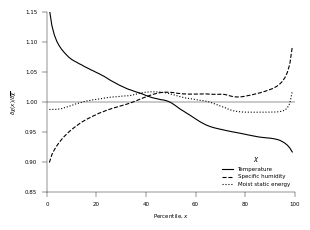

In [135]:
save_lambda_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
labels = ['Temperature','Specific humidity', 'Moist static energy']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = [np.expand_dims(var[1] - var[0], axis=-1) for var in [temp_mean, sphum_mean, mse_mean]]
linestyles = ['-', '--', ':']
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    var_ratio = (var[1]-var[0])/delta_var_mean[i]
    ax.plot(quant_plot, np.average(var_ratio, axis=0, weights=lat_weights), label=labels[i], color='k', linestyle=linestyles[i])
delta_mse_ratio = var_ratio
ax.hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax.legend(title='$\chi$')
ax.set_xlabel('Percentile, $x$')
ax.set_ylabel('$\delta \chi(x)/\delta \overline{\chi}$')
ax.set_ylim(0.85,1.15)
ax.set_xlim(0, 100)
plt.tight_layout()
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight')

## Equating Percentiles Approximation 

This plot investigates whether $\delta h(x_h) \approx c_p \delta T(x_T) + L_v \delta q(x_q)$ is valid.

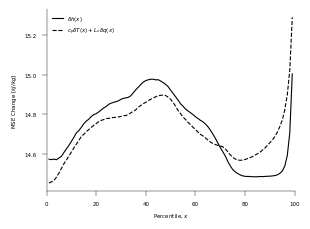

In [112]:
save_delta_mse_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(mse_quant2[1]-mse_quant2[0], axis=0, weights=lat_weights), label = '$\delta h(x)$', color='k')
ax.plot(quant_plot, np.average(c_p * (temp_quant2[1]-temp_quant2[0]) +
                               L_v * (sphum_quant2[1]-sphum_quant2[0]), axis=0, weights=lat_weights)/1000,
        label='$c_p \delta T(x) + L_v \delta q(x)$', color='k', linestyle='--')
ax.legend()
ax.set_xlabel('Percentile, $x$')
ax.set_ylabel('MSE Change [$kJ/kg$]')
ax.set_xlim(0,100)
plt.tight_layout()

if save_fig or save_delta_mse_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_mse_{region.lower()}_{season}", 
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight')

## Theoretical Temperature Change
Below, we plot whether the theory can correctly predict the temperature change between adjacent simulations.

In [113]:
temp_diff_theory = {method: np.zeros((n_lat, n_quant)) for method in ['linear', 'const_rh', 'squared', 'squared_lambda']}
for method in temp_diff_theory:
    for i in range(n_lat):
        temp_diff_theory[method][i] = \
            get_delta_temp_quant_theory(temp_mean[:, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface,
                                        const_rh=True if method=='const_rh' else False,
                                        delta_mse_ratio=delta_mse_ratio[i:i+1] if 'lambda' in method else None,
                                        taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')


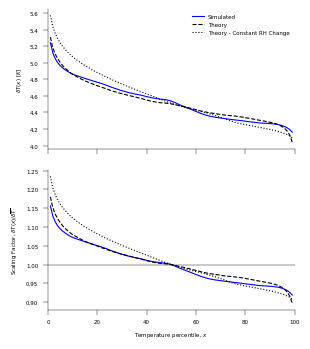

In [118]:
# take median as average rather than mean because theory does not predict change to mean temperature
save_theory_fig = True
av_quant_ind = np.where(quant_plot==50)[0]
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 1.5*(width['one_col']/ar)), sharex=True)
ax[0].plot(quant_plot, np.average(temp_quant2[1]-temp_quant2[0], axis=0, weights=lat_weights), label = 'Simulated', color='blue')
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'], axis=0, weights=lat_weights), color='k', linestyle='--',
           label='Theory')
ax[0].plot(quant_plot, np.average(temp_diff_theory['const_rh'], axis=0, weights=lat_weights), color='k',
           label='Theory - Constant RH Change', linestyle=':')
ax[1].plot(quant_plot, np.average((temp_quant2[1]-temp_quant2[0])/(temp_quant2[1]-temp_quant2[0])[:, av_quant_ind],
                                  axis=0, weights=lat_weights), label = 'Simulated', color='b')
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear']/temp_diff_theory['linear'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(temp_diff_theory['const_rh']/temp_diff_theory['const_rh'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', label='Theory - Constant RH Change', linestyle=':')
ax[1].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].legend()
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ [$K$]')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
# ax[1].set_ylim(0.8, 1.5)
# ax[0].set_ylim(3.5, 6.5)
# ax[0].set_ylim(4, 5.6)
# ax[1].set_ylim(0.89, 1.25)
plt.tight_layout()

if save_fig or save_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_{region.lower()}_{season}",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight')

### Gamma, $\gamma$, Plots
The dashed theory above is given by $\delta T(x) = \gamma^T \delta \overline{T} + \gamma^{\Delta r} \delta (\overline{r}-r(x))$ and the dotted line is just $\gamma^T \delta \overline{T}$. The plots below show how these $\gamma$ factors vary with percentile.

In [119]:
gamma_t = np.zeros((n_lat, n_quant))
gamma_rdiff = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    all_gamma = get_gamma(temp_mean[:, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface)
    gamma_t[i] = all_gamma[0][0]
    gamma_rdiff[i] = all_gamma[1][0]

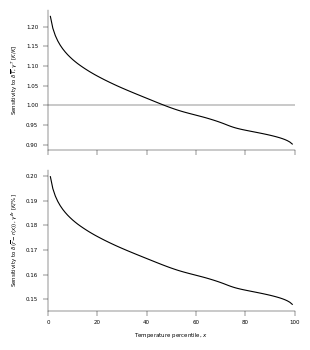

In [124]:
save_gamma_fig = True
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 1.5*(width['one_col']/ar)), sharex=True)
ax[0].plot(quant_plot, np.average(gamma_t, axis=0, weights=lat_weights), color='k')
ax[1].plot(quant_plot, np.average(gamma_rdiff/100, axis=0, weights=lat_weights), color='k')
ax[0].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].set_ylabel('Sensitivity to $\delta \overline{T}$, $\gamma^T$ [$K/K$]')
ax[1].set_ylabel('Sensitivity to $\delta (\overline{r} - r(x))$, $\gamma^{\Delta r}$ [$K/$%]')
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
plt.tight_layout()
if save_fig or save_gamma_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_{region.lower()}_{season}",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight')

## Failure of Theory
Below, I plot a hierarchy of theories to see which approximation causes the breakdown of the theory.
There are three approximations that go into the theory:
1. $\lambda = \delta h(x)/\delta \overline{h} = 1$

    The validity of this is shown by the green line in the $\delta \chi/\delta \overline{\chi}$ plot. This should be equal to 1.
    In the top plot below, we see that whenever $\lambda < 1$, the green line, which includes the exact $\lambda$, predicts a smaller temperature change than the orange line which is the same apart from assuming $\lambda=1$.

2. $\delta h(x) \approx c_p \delta T(x) + L_v \delta q(x)$

    The validity of this is shown in the MSE Change plot. If this approximation was exact, we would expect the solid and dashed lines to match up exactly.
   In the top plot below, we see that whenever $c_p \delta T(x) + L_v \delta q(x) > \delta h(x)$, the predicted temperature change by the most complete theory (green line) is less than the actual simulated value (blue line).

3. Taylor series for $\delta q(x)$ in terms of $\delta T(x)$ and $\delta r(x)$ as well as for $\delta \overline{q}$

    The most accurate taylor series I use is to include squared, $\delta T^2$, nonlinear, $\delta T \delta r$, and linear terms. The extent to which just the linear terms are necessary can be evaluated by comparing the orange and black dashed line below. The only difference between them is that the orange line retains all the terms in the taylor series.

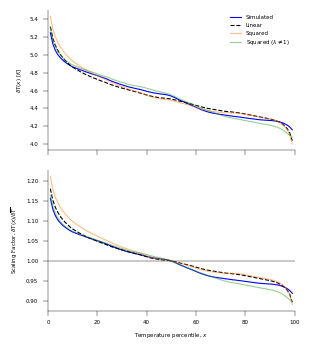

In [126]:
save_approx_fig = True
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 1.5*(width['one_col']/ar)), sharex=True)
ax[0].plot(quant_plot, np.average(temp_quant2[1]-temp_quant2[0], axis=0, weights=lat_weights), label = 'Simulated', color='blue')
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'], axis=0, weights=lat_weights), color='k', linestyle='--',
           label='Linear')
ax[0].plot(quant_plot, np.average(temp_diff_theory['squared'], axis=0, weights=lat_weights), color=default_colors[1],
           label='Squared', alpha=0.5)
ax[0].plot(quant_plot, np.average(temp_diff_theory['squared_lambda'], axis=0, weights=lat_weights), color=default_colors[2],
           label='Squared ($\lambda \\neq 1$)', alpha=0.5)
ax[1].plot(quant_plot, np.average((temp_quant2[1]-temp_quant2[0])/(temp_quant2[1]-temp_quant2[0])[:, av_quant_ind],
                                  axis=0, weights=lat_weights), label = 'Simulated', color='b')
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear']/temp_diff_theory['linear'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(temp_diff_theory['squared']/temp_diff_theory['squared'][:, av_quant_ind], axis=0, weights=lat_weights),
           color=default_colors[1], alpha=0.5)
ax[1].plot(quant_plot, np.average(temp_diff_theory['squared_lambda']/temp_diff_theory['squared_lambda'][:, av_quant_ind],
                                  axis=0, weights=lat_weights), color=default_colors[2], alpha=0.5)

ax[1].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].legend()
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ [$K$]')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
plt.tight_layout()

if save_fig or save_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_approx_{region.lower()}_{season}",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight')

## Relative Humidity
Below, I plot how the relative humidity changes between the simulations for each quantile. Whenever the change in relative humidity on a percentile $x$ day is less than on the mean day, $\delta (\bar{r} - r) > 0$, we get a positive contribution to $\delta T$.

Note, that this relative humidity is not a physical quantity. $r(x)$ is equal to the $x$ percentile of specific humidity, $q(x)$, divided by the saturation specific humidity evaluated on the $x$ percentile temperature day, $q_{sat}(T(x))$.

In [128]:
r_mean2 = sphum_mean / sphum_sat(temp_mean, p_surface) * 100
r_quant2 = sphum_quant2 / sphum_sat(temp_quant2, p_surface) * 100

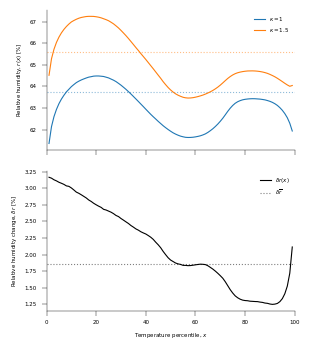

In [131]:
save_rh_fig = True
# choose which mean rh to plot - r_mean is mean over all RH values. r_mean2 is mean sphum divided by sphum_sat evaluated at mean temp.
# r_mean_use = r_mean
r_mean_use = r_mean2
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 1.5*(width['one_col']/ar)), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(r_quant2[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax[0].hlines(np.average(r_mean_use[i], weights=lat_weights), 0, 100, color=default_colors[i], linestyle=':', alpha=0.5)
ax[1].plot(quant_plot, np.average(r_quant2[1]-r_quant2[0], axis=0, weights=lat_weights), color='k', label='$\delta r(x)$')
ax[1].hlines(np.average(r_mean_use[1]-r_mean_use[0], axis=0, weights=lat_weights), 0, 100, color='k', linestyles=':', label='$\delta \overline{r}$', alpha=0.5)
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Relative humidity, $r(x)$ [%]')
ax[1].set_ylabel('Relative humidity change, $\delta r$ [%]')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
plt.tight_layout()

if save_fig or save_rh_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh_{region.lower()}_{season}",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight')

## Specific humidity
Below, I plot the specific humidity in the reference (colder) simulation as a function of percentile. The fact that this increases with x is the reason we see suppressed warming of the hottest days.

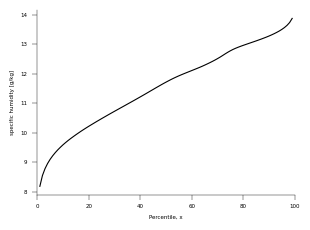

In [134]:
save_sphum_fig = True
include_mean = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quant_plot, np.average(sphum_quant2[0], axis=0, weights=lat_weights)*1000, color='k', label='$q(x)$')
if include_mean:
    ax.hlines(np.average(sphum_mean[0], weights=lat_weights)*1000, 0, 100, colors='k', label='$\overline{q}$', linestyle=':')
    ax.legend()
ax.set_xlim(0,100)
ax.set_ylabel('specific humidity [g/kg]')
ax.set_xlabel('Percentile, x')
plt.tight_layout()
if save_sphum_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sphum_{region.lower()}_{season}",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight')

## Theory as function of latitude
The plot below shows how the theory works as a function of latitude for the subset of quantiles.

In [27]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av[::-1]     # invert order so latitude is increasing

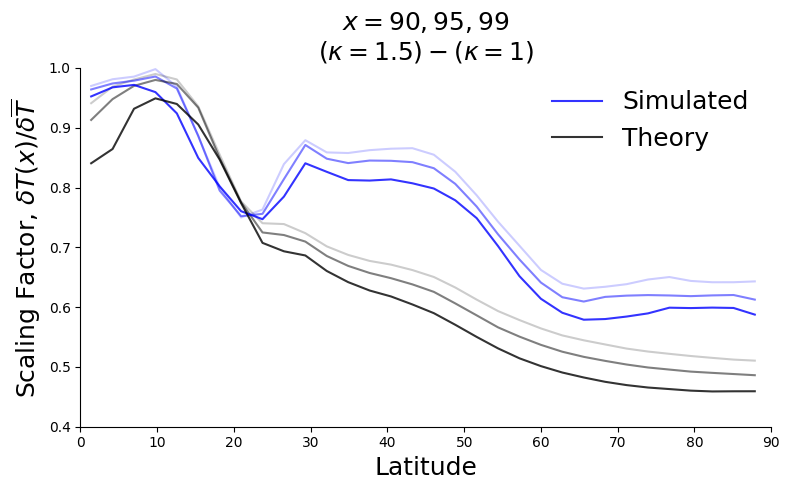

In [53]:
quant_subset = [90,95,99]
quant_subset_ind = numpy_indexed.indices(quant_plot, quant_subset)
lat_plot = ds_all[0].lat[int(n_lat/2):]

big_font_size = 18      # for posters

save_theory_lat_fig = False
include_theory = True
fig_theory_lat, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
for i in range(len(quant_subset)):
    ax.plot(lat_plot, abs_lat_av((temp_quant2[1, :, quant_subset_ind[i]]-temp_quant2[0, :, quant_subset_ind[i]])/
                                 (temp_quant2[1]-temp_quant2[0])[:, av_quant_ind[0]]), color='blue', alpha=0.2+i*0.3,
            label='Simulated' if i==2 else None)
    if include_theory:
        ax.plot(lat_plot, abs_lat_av(temp_diff_theory['linear'][:, quant_subset_ind[i]]/
                                     temp_diff_theory['linear'][:, av_quant_ind[0]]), color='k', alpha=0.2+i*0.3,
                label='Theory' if i==2 else None)
ax.set_title(f"$x={','.join([str(x) for x in quant_subset])}$\n"
             f"$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$", fontsize=big_font_size)
ax.set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$', fontsize=big_font_size)
ax.set_xlabel('Latitude', fontsize=big_font_size)
if include_theory:
    ax.legend(frameon=False, fontsize=big_font_size)
ax.set_xlim(0,90)
ax.set_ylim(0.4, 1)
plt.tight_layout()
if (save_fig or save_theory_lat_fig) and region=='Global':
    fig_theory_lat.savefig(f"/Users/joshduffield/Desktop/temp_theory_lat_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## $\lambda$ Decompostion
Here, I break down the $\lambda=1$ approximation into three different factors. $\lambda_1$ represents CQE on the $x$ percentile day. $\lambda_2$ represents the weak temperature gradient approximation and $\lambda_3$ represents CQE on the mean day.

In [29]:
lambda_1 = (mse_quant3[1] - mse_quant3[0]) / (mse_ft_sat_quant3[1]-mse_ft_sat_quant3[0])
lambda_2 = (mse_ft_sat_quant3[1]-mse_ft_sat_quant3[0]) / np.expand_dims(mse_ft_sat_mean[1]-mse_ft_sat_mean[0], axis=-1)
lambda_3 = (mse_mean[1]-mse_mean[0]) / (mse_ft_sat_mean[1]-mse_ft_sat_mean[0])
labels = ['$\lambda(x) = \delta h(x)/\delta \overline{h} = \lambda_1(x) \lambda_2(x) \lambda_3^{-1}$',
          '$\lambda_1(x) = \delta h(x) / \delta h_{FT, sat}(x)$',
          '$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$',
          '$\lambda_3 = \delta \overline{h} / \delta \overline{h}_{FT, sat}$']

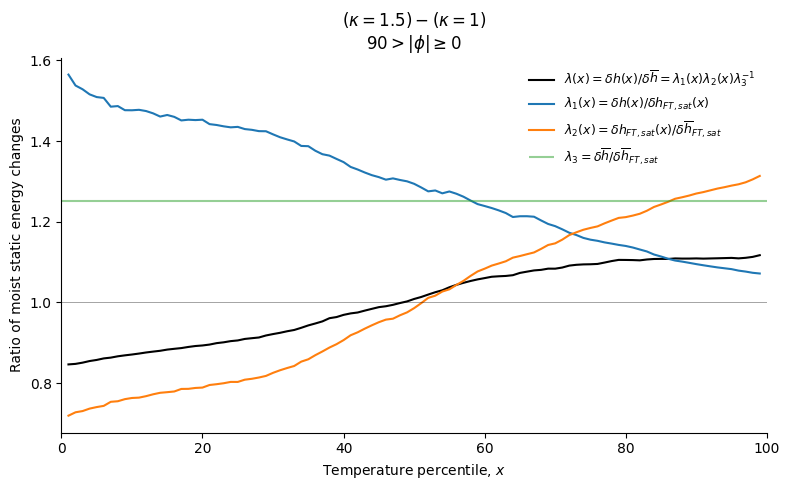

In [30]:
save_lambda_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quant_plot, np.average(var, axis=0, weights=lat_weights),
            color=use_color, label=labels[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(np.average(lambda_3, axis=0, weights=lat_weights), 0, 100, color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, 0, 100, color='k', lw=0.5, alpha=0.5)
ax.legend(framealpha=1, edgecolor='white', fontsize=9)
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Ratio of moist static energy changes')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()
if save_fig or save_lambda_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

In the plot below, the quantiles in the order $90, 95, 99$ are represented in terms of lines of increasing opacity i.e. the darkest lines represent $x=99$.


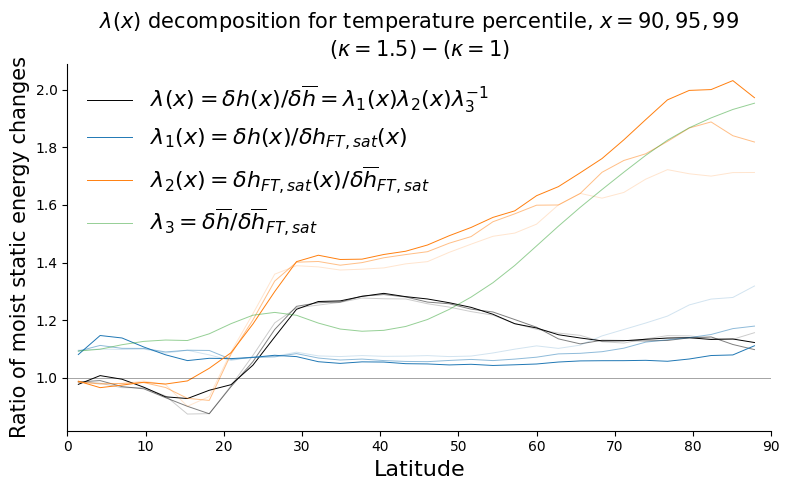

In [54]:
save_lambda_decomp_lat_fig = False
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=0.2, color=use_color, lw=0.7)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=0.5, color=use_color, lw=0.7)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=1, color=use_color, label=labels[i], lw=0.7)
ax.plot(lat_plot, abs_lat_av(lambda_3), color=default_colors[2], alpha=0.5, label=labels[3], lw=0.7)
ax.hlines(1, -90, 90, color='k', lw=0.5, alpha=0.5)
ax.set_xlim(0, 90)
ax.legend(frameon=False, fontsize=big_font_size-2)
ax.set_xlabel('Latitude', fontsize=big_font_size-2)
ax.set_ylabel('Ratio of moist static energy changes', fontsize=big_font_size-3)
ax.set_title(f"$\lambda(x)$ decomposition for temperature percentile, $x={','.join([str(x) for x in quant_subset])}$\n"
             f"$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$", fontsize=big_font_size-3)
plt.tight_layout()
if (save_fig or save_lambda_decomp_lat_fig) and region=='Global':
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_lat_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

The above suggests that for the warmest near-surface days, the near-surface temperature increases less than average but the free troposphere temperature increases more than average. I show that explicitly below. This is most apparent at high latitudes.

Note in the plot below, the denominator is the change in median temperature, not in mean. This is why the orange line in the left plot below is slightly different to the green $\lambda_{2_{\delta}}$ line in the $\lambda_2$ vs latitude plot.

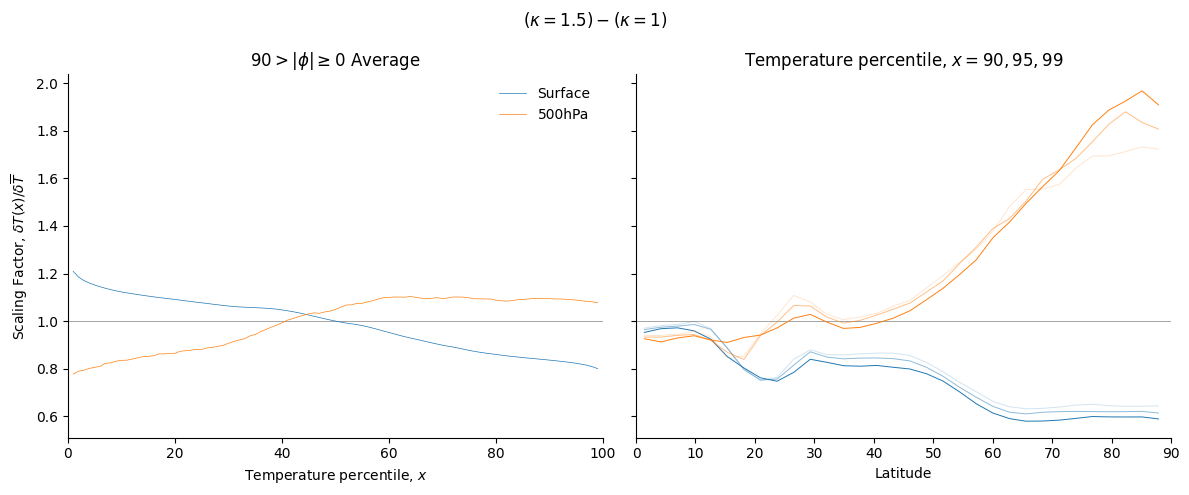

In [32]:
save_temp_ft_fig = False
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True)
for i in range(len(ax)):
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].hlines(1, 0, 100, color='k', lw=0.5, alpha=0.5)
for i, var in enumerate([temp_quant3[1]-temp_quant3[0], temp_ft_quant3[1]-temp_ft_quant3[0]]):
    av_change = var[:, av_quant_ind] if i == 0  else np.expand_dims(temp_ft_median[1]-temp_ft_median[0], axis=-1)

    ax[0].plot(quant_plot, np.average(var/av_change, axis=0, weights=lat_weights), color=default_colors[i],
               label='Surface' if i ==0 else f'{pressure_ft}hPa', lw=0.5)
    ax[1].plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]/av_change[:, 0]), color=default_colors[i], alpha=0.2, lw=0.7)
    ax[1].plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]/av_change[:, 0]), color=default_colors[i], alpha=0.5, lw=0.7)
    ax[1].plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]/av_change[:, 0]), color=default_colors[i], alpha=1, lw=0.7)

ax[0].set_xlim(0, 100)
ax[1].set_xlim(0, 90)
ax[0].legend(frameon=False)
ax[0].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[1].set_xlabel('Latitude')
ax[0].set_title(f'${lat_max}>|\phi| \geq {lat_min}$ Average')
ax[1].set_title(f"Temperature percentile, $x={','.join([str(x) for x in quant_subset])}$")
fig.suptitle(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
plt.tight_layout()
if save_fig or save_temp_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_ft_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## $\lambda_2$ Decomposition
$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$ can be split up into a product of two terms:
$$\lambda_2(x) = \frac{c_p+L_v\alpha(T_{FT}(x))q^*(T_{FT}(x))}{c_p+L_v\alpha(\overline{T_{FT}})q^*(\overline{T_{FT}})} \times
\frac{\delta T_{FT}(x)}{\delta \overline{T_{FT}}$$
The first term being just evaluated at the historical simulation, and the second incorporating temperature changes. This equation assumes no changes to the geopotential height term, but in zhang 2023, these can be related to temperature as well.
I label these contributions as $\lambda_{2_0}$ and $\lambda_{2_{\delta}}$ respectively.

The black and blue lines below differ, indicating that the geopotential height or potentialy squared temperature, $\delta T^2$ terms may be important.

In [33]:
lambda_2_0 = (c_p + L_v * clausius_clapeyron_factor(temp_ft_quant3[0], pressure_ft_actual) *
              sphum_sat(temp_ft_quant3[0], pressure_ft_actual)) / np.expand_dims(
    c_p + L_v * clausius_clapeyron_factor(temp_ft_mean[0], pressure_ft_actual) * sphum_sat(temp_ft_mean[0], pressure_ft_actual), axis=-1)
lambda_2_delta = (temp_ft_quant3[1]-temp_ft_quant3[0])/np.expand_dims(temp_ft_mean[1]-temp_ft_mean[0], axis=-1)

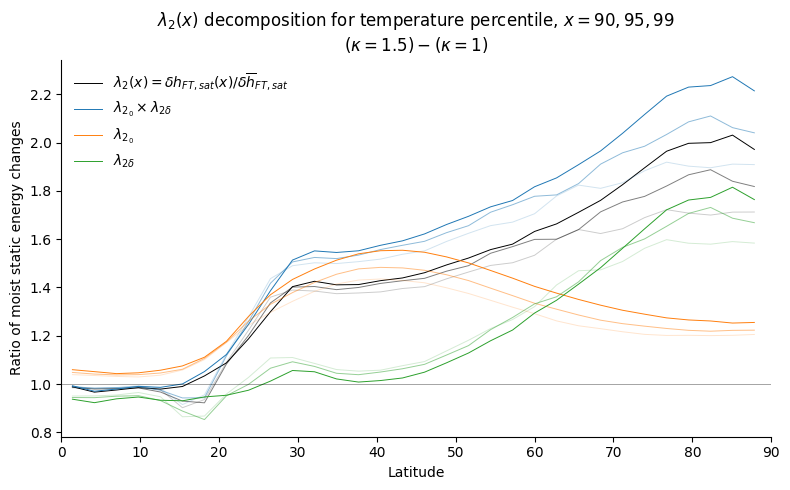

In [34]:
save_lambda2_decomp_lat_fig = False
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
labels_lambda2 = ['$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$',
                  '$\lambda_{2_0} \\times \lambda_{2\delta}$', '$\lambda_{2_0}$', '$\lambda_{2\delta}$']
for i, var in enumerate([lambda_2, lambda_2_0 * lambda_2_delta, lambda_2_0, lambda_2_delta]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=0.2, color=use_color, lw=0.7)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=0.5, color=use_color, lw=0.7)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=1, color=use_color, label=labels_lambda2[i], lw=0.7)
ax.hlines(1, -90, 90, color='k', lw=0.5, alpha=0.5)
ax.set_xlim(0, 90)
ax.legend(frameon=False)
ax.set_xlabel('Latitude')
ax.set_ylabel('Ratio of moist static energy changes')
ax.set_title(f"$\lambda_2(x)$ decomposition for temperature percentile, $x={','.join([str(x) for x in quant_subset])}$\n"
             f"$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$")
plt.tight_layout()
if (save_fig or save_lambda2_decomp_lat_fig) and region=='Global':
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_decomp_lat_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

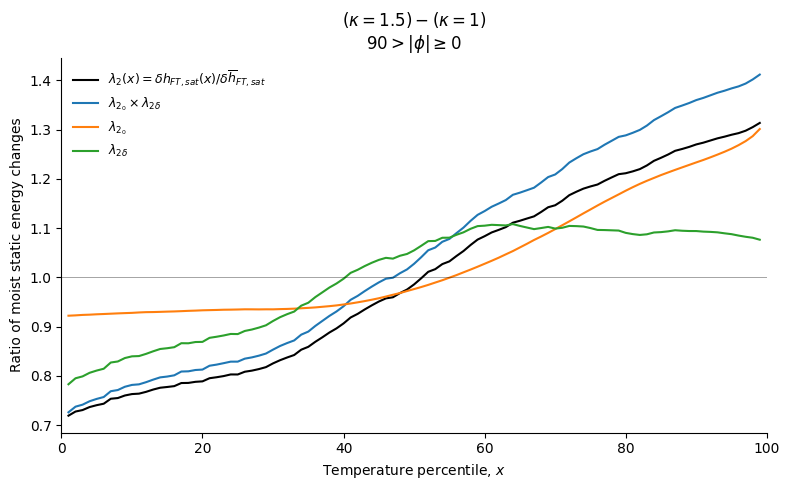

In [35]:
save_lambda2_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_2, lambda_2_0 * lambda_2_delta, lambda_2_0, lambda_2_delta]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quant_plot, np.average(var, axis=0, weights=lat_weights),
            color=use_color, label=labels_lambda2[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(1, 0, 100, color='k', lw=0.5, alpha=0.5)
ax.legend(framealpha=1, edgecolor='white', fontsize=9)
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Ratio of moist static energy changes')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()
if save_fig or save_lambda2_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_decomp_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

In [36]:
# back of envelope estimate of effect of geopotential height
# should probably add line to above plot including geopotential height and see the difference it makes
10 * (ds_all_ft[1].height.mean(dim='lon_time') - ds_all_ft[0].height.mean(dim='lon_time')) / 1000

<xarray.DataArray 'height' (lat: 64)>
array([1.6469092, 1.6418164, 1.6338282, 1.6235449, 1.6111377, 1.596748 ,
       1.5792334, 1.5572461, 1.5323535, 1.5080078, 1.4869092, 1.4706591,
       1.457622 , 1.4415381, 1.4180908, 1.3890283, 1.356997 , 1.3229785,
       1.2883545, 1.2532372, 1.2158692, 1.176704 , 1.1404248, 1.113794 ,
       1.100503 , 1.0975733, 1.1000293, 1.106538 , 1.1158203, 1.1238574,
       1.1290234, 1.1320312, 1.1321533, 1.1291113, 1.1236132, 1.1147119,
       1.1030078, 1.0925782, 1.0879493, 1.0941455, 1.1152978, 1.1482861,
       1.1852978, 1.2226465, 1.2597216, 1.2942529, 1.3244336, 1.3513281,
       1.3765869, 1.4003564, 1.4219873, 1.4423926, 1.4648389, 1.4904785,
       1.5155567, 1.5341699, 1.5429492, 1.5443653, 1.5454444, 1.5512402,
       1.5606543, 1.5702832, 1.5783447, 1.5837256], dtype=float32)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
    pfull    float64 486.9

## Add $\lambda_{2_0}$ to theory
The orange line in the theory below assumes that $\lambda_1 = \lambda_3$ and $\lambda_2 = \lambda_{2_0}$. These combine to give $\lambda = \lambda_{2_0}$ rather than $\lambda=1$.

This seems to improve things at higher latitudes.

In [37]:
temp_diff_theory['lambda_2'] = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    temp_diff_theory['lambda_2'][i] = \
        get_delta_temp_quant_theory(temp_mean[:, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface,
                                    const_rh=False, delta_mse_ratio=lambda_2_0[i:i+1], taylor_level='linear_rh_diff')

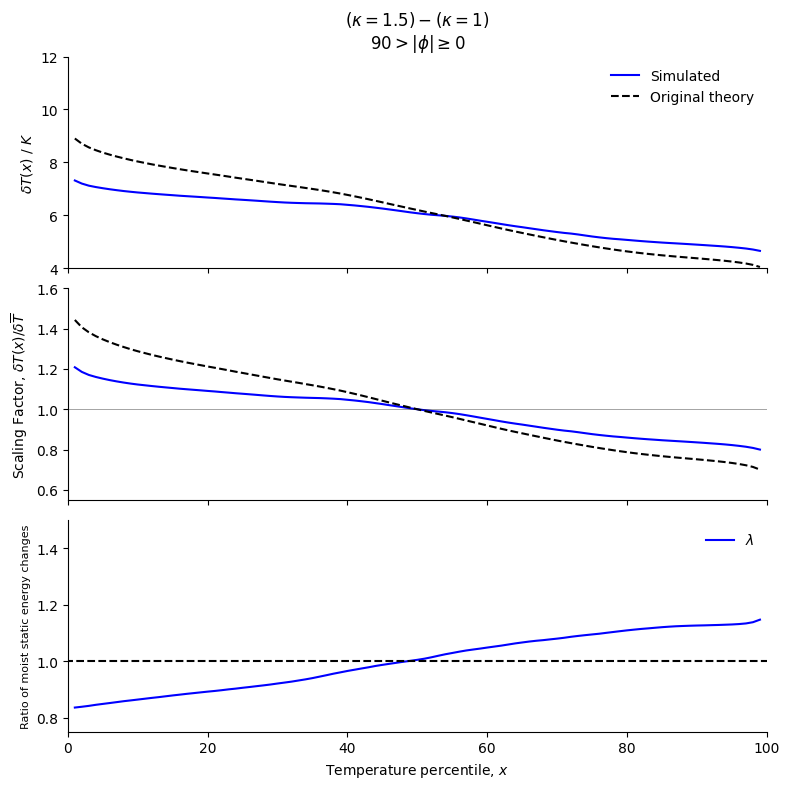

In [40]:
save_lambda2_theory_fig = False
fig, ax = plt.subplots(3,1, figsize=(8, 8), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[2].spines[['right', 'top']].set_visible(False)
ax[0].plot(quant_plot, np.average(temp_quant2[1]-temp_quant2[0], axis=0, weights=lat_weights), label = 'Simulated', color='blue')
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'], axis=0, weights=lat_weights), color='k', linestyle='--',
           label='Original theory')
# ax[0].plot(quant_plot, np.average(temp_diff_theory['lambda_2'], axis=0, weights=lat_weights), color=default_colors[1],
#            label='Modified theory')
ax[1].plot(quant_plot, np.average((temp_quant2[1]-temp_quant2[0])/(temp_quant2[1]-temp_quant2[0])[:, av_quant_ind],
                                  axis=0, weights=lat_weights), label = 'Simulated', color='b')
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear']/temp_diff_theory['linear'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', linestyle='--')
# ax[1].plot(quant_plot, np.average(temp_diff_theory['lambda_2']/temp_diff_theory['lambda_2'][:, av_quant_ind], axis=0, weights=lat_weights),
#            color=default_colors[1])
# Add lambda comparison
for i, var in enumerate([delta_mse_ratio]):
    ax[2].plot(quant_plot, np.average(var, axis=0, weights=lat_weights),
            color='b' if i == 0 else default_colors[1], label='$\lambda$' if i==0 else '$\lambda_{2_0}$')
ax[1].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=0.5)
ax[2].hlines(1, -10, 100, linestyles='--', color='k')
ax[2].set_ylabel('Ratio of moist static energy changes', fontsize=8)
ax[2].legend(frameon=False)
ax[0].legend(frameon=False)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()
ax[0].set_ylim(4,12)
ax[1].set_ylim(0.55,1.6)
ax[2].set_ylim(0.75,1.5)

if save_fig or save_lambda2_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_lambda2_theory_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

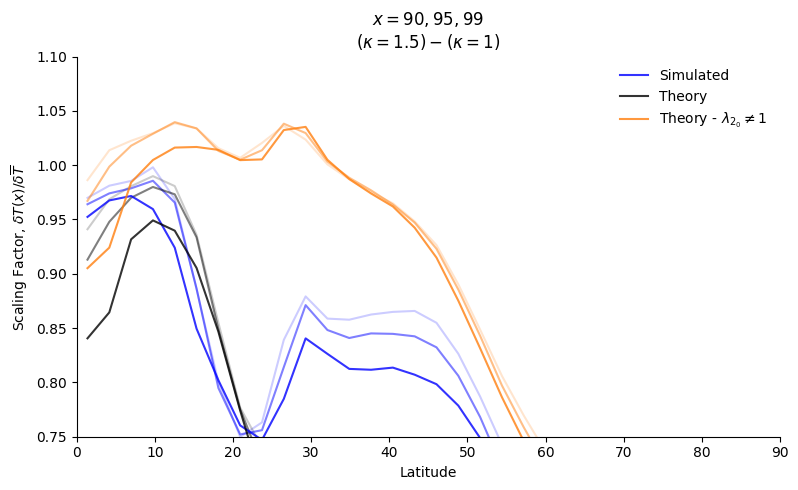

In [39]:
save_theory_lambda2_lat_fig = False
fig = copy.deepcopy(fig_theory_lat)
ax = fig.gca()
for i in range(len(quant_subset)):
    ax.plot(lat_plot, abs_lat_av(temp_diff_theory['lambda_2'][:, quant_subset_ind[i]]/
                             temp_diff_theory['lambda_2'][:, av_quant_ind[0]]), color=default_colors[1], alpha=0.2+i*0.3,
        label='Theory - $\lambda_{2_0} \\neq 1$' if i==2 else None)
ax.legend(frameon=False)
ax.set_ylim(0.75, 1.1)

if (save_fig or save_theory_lambda2_lat_fig) and region=='Global':
    fig.savefig(f"/Users/joshduffield/Desktop/temp_theory_lambda2_lat_{season}",
                dpi=high_dpi if publish_fig else low_dpi)
fig